# Basic correction and evaluation

This example corrects a small set of aerial images and evaluates the results.  

Images are taken from the `homonim` test data: Aerials were obtained from [NGI](https://ngi.dalrrd.gov.za/), and subsequently downsampled and re-scaled to *uint8* precision to reduce size.  Satellite images were acquired with [geedim](https://github.com/dugalh/geedim), and re-scaled to *uint8* precision.  

The notebook uses the APIs of `homonim` and other packages.  Where equivalent CLI commands are available, they are given in the comments.


## Setup

In [1]:
# matplotlib and gdal should be installed if they aren't already.
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge gdal matplotlib
# else:
#     # install into the conda environment the notebook is being run from
#     !{sys.executable} -m pip install gdal matplotlib

In [2]:
import logging
from pathlib import Path
from matplotlib import pyplot
import rasterio as rio
from rasterio.plot import show
import numpy as np
from homonim import RasterFuse, RasterCompare, Model

logging.basicConfig(level=logging.ERROR)

In [3]:
# create URLS of homonim source and reference images.
src_paths = [
    f'https://raw.githubusercontent.com/dugalh/homonim/main/'
    f'tests/data/source/ngi_rgb_byte_{i}.tif' 
    for i in range(1, 5)
]
ref_path = (
    'https://raw.githubusercontent.com/dugalh/homonim/main/'
    'tests/data/reference/sentinel2_b432_byte.tif'
)

## Surface reflectance correction

Here, we fuse each aerial image with a Sentinel-2 reference using the `RasterFuse` class.  Source and reference images are RGB, so there is no need to specify `src_bands` or `ref_bands` parameters.

In [4]:
# corrected file names corresponding to source names
corr_paths = [f'corr_{Path(src_path).stem}.tif' for src_path in src_paths]

for src_path, corr_path in zip(src_paths, corr_paths):
    with RasterFuse(src_path, ref_path) as raster_fuse:
        raster_fuse.process(
            corr_path, Model.gain_blk_offset, (5, 5), overwrite=True
        )

    # equivalent homonim command line:
    # !homonim fuse -m gain-blk-offset -k 5 5 -o {src_path} {ref_path}


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

## Visualisation

Next, we create a VRT mosaic of the corrected images to assist with visualisation and evaluation.

In [5]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_path = 'corr_ngi_mosaic_rgb_byte.vrt'
_ = gdal.BuildVRT(corr_mosaic_path, corr_paths)

Now we can display a zoomed-in area of the source mosaic, reference image and corrected mosaic.

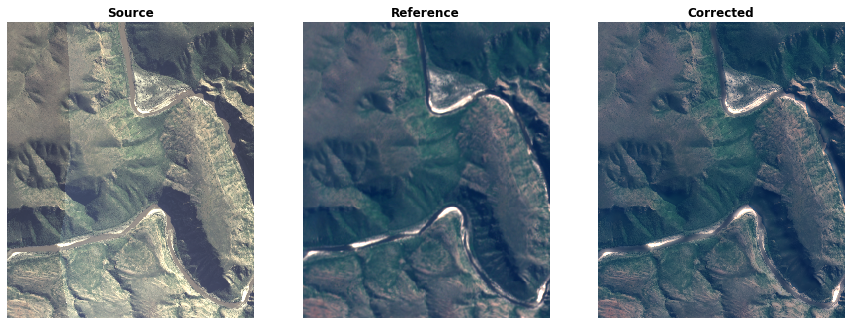

In [6]:
# VRT mosaic of the source files
src_mosaic_path = (
    'https://raw.githubusercontent.com/dugalh/homonim/main/'
    'tests/data/source/ngi_mosaic_rgb_byte.vrt'
)

fig, axes = pyplot.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 10))

for im_file, scale, axis, label in zip(
    [src_mosaic_path, ref_path, corr_mosaic_path],
    [255, 150, 150],
    axes,
    ['Source', 'Reference', 'Corrected'], 
):   
    # read, scale and display the image
    with rio.open(im_file, 'r') as ds:
        array = ds.read(out_dtype='float32') / scale
        
        show(array, transform=ds.transform, ax=axis, interpolation='nearest')
        axis.set_title(label, fontweight='bold')
        axis.set_xlim(-5.75e4, -5.50e4)  # zoom in
        axis.set_ylim(-3.733e6, -3.730e6) 
        axis.axis('off')

Note that a visible seamline between images in the source mosaic has been removed, and the corrected and reference surface reflectances are visually similar.  

## Evaluation

Finaly, we compare the *source* and *corrected* similarity with a second (Landsat-8) *reference*.  This comparison gives us an indication of the change in surface reflectance accuracy due to correction.  

As a first step, we produce tables of comparison statistics with using the `RasterCompare` class.

In [7]:
# URL of the Landsat-8 reference
cmp_ref_path = (
    'https://raw.githubusercontent.com/dugalh/homonim/main/'
    'tests/data/reference/landsat8_byte.tif'
)
print(RasterCompare.schema_table())

# loop over the source and corrected image files
for im_path, im_label in zip(
    [src_mosaic_path, corr_mosaic_path],
    ['Source', 'Corrected'],
):
    with RasterCompare(im_path, cmp_ref_path) as compare:
        # print a table of comparison statistics (the typical way of using 
        # RasterCompare)
        stats_dict = compare.process()
        print(f'{im_label} comparison:\n\n' + compare.stats_table(stats_dict))

    # equivalent homonim command line:
    # !homonim compare {im_path} {cmp_ref_path}

ABBREV   DESCRIPTION
-------- -----------------------------------------
r²       Pearson's correlation coefficient squared
RMSE     Root Mean Square Error
rRMSE    Relative RMSE (RMSE/mean(ref))
N        Number of pixels


  0%|                                                                                                         …

Source comparison:

  Band    r²   RMSE   rRMSE     N
------ ----- ------ ------- -----
 SR_B4 0.639 79.247   1.746 76143
 SR_B3 0.549 83.168   1.859 76143
 SR_B2 0.409 94.104   3.169 76143
  Mean 0.533 85.506   2.258 76143


  0%|                                                                                                         …

Corrected comparison:

  Band    r²   RMSE   rRMSE     N
------ ----- ------ ------- -----
 SR_B4 0.938  9.815   0.216 76143
 SR_B3 0.922  6.892   0.154 76143
 SR_B2 0.862 30.966   1.043 76143
  Mean 0.907 15.891   0.471 76143


Then, we use `RasterCompare` again, but this time to read spatially matching bands from the *source* / *corrected* - *reference* pairs.  From these bands, we produce scatter plots of *source* / *corrected* vs. *reference* surface reflectance. 

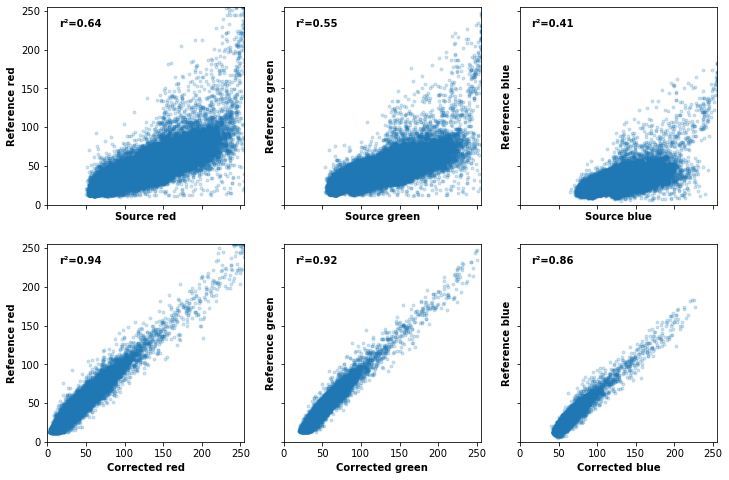

In [8]:
fig, axes = pyplot.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

# loop over the source and corrected image files and corresponding axes etc
for im_i, im_path, axis, im_label in zip(
    range(2),
    [src_mosaic_path, corr_mosaic_path],
    axes,
    ['Source', 'Corrected'],
):
    with RasterCompare(im_path, cmp_ref_path) as compare:
        # produce per-band scatter plots of source/corrected - reference 
        # surface reflectance 
        # (note that a 'block' takes the size of a band here as the band size
        # is substantially smaller than default 'max_block_mem' parameter)
        for band_i, block_pair, band_label in zip(
            range(3),
            compare.block_pairs(),
            ['red', 'green', 'blue']
        ):
            # read source/corrected - reference band pair, and reproject the 
            # source/corrected band to the reference CRS and pixel grid
            src_ra, ref_ra = compare.read(block_pair)
            src_ra = src_ra.reproject(
                **ref_ra.proj_profile, resampling='average'
            )

            # vectors of valid pixels in the source/corrected and reference bands
            mask = src_ra.mask & ref_ra.mask  # mask of valid pixels
            src_v, ref_v = src_ra.array[mask], ref_ra.array[mask]
            r2 = np.corrcoef(src_v, ref_v)[0, 1] ** 2 

            # create scatter plot
            axis = axes[im_i, band_i]
            axis.plot(src_v, ref_v, '.', alpha=0.2)
            axis.set_xlim(0, 255)
            axis.set_ylim(0, 255)
            axis.text(15, 230, f'r\N{SUPERSCRIPT TWO}={r2:.2f}', fontweight='bold')
            axis.set_xlabel(f'{im_label} {band_label}', fontweight='bold')
            axis.set_ylabel(f'Reference {band_label}', fontweight='bold')

The $r^2$ values and scatter plots show a useful improvement after correction.  